In [12]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
Simport os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, UpSampling2D, concatenate, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten, Dense, Input, GlobalAveragePooling2D

In [ ]:
data_dir = '/content/drive/Shareddrives/DeepLearning_2024/FinalProject/Data/kvasir-seg'
results_dir = '/content/drive/Shareddrives/DeepLearning_2024/FinalProject/Results'

# **Data Load**

In [ ]:
# Load and preprocess the data
def load_data(image_dir, mask_dir, img_size=(224, 224)):
    images = []
    masks = []
    for img_name in os.listdir(image_dir):
        img_path = os.path.join(image_dir, img_name)
        mask_path = os.path.join(mask_dir, img_name)

        img = load_img(img_path, target_size=img_size)
        mask = load_img(mask_path, target_size=img_size, color_mode='grayscale')

        img = img_to_array(img) / 255.0
        mask = img_to_array(mask) / 255.0

        images.append(img)
        masks.append(mask)

    images = np.array(images)
    masks = np.array(masks)

    # Standardize images
    mean = np.mean(images)
    std = np.std(images)
    images = (images - mean) / std

    return images, masks

# Paths to the dataset
image_dir = data_dir + '/images'
mask_dir = data_dir + '/masks'

# Load data
images, masks = load_data(image_dir, mask_dir)

In [ ]:
# Split data into training, validation, and test sets
train_images, test_images, train_masks, test_masks = train_test_split(images, masks, test_size=0.3, random_state=42)
train_images, val_images, train_masks, val_masks = train_test_split(train_images, train_masks, test_size=0.3, random_state=42)

In [ ]:
def visualize_results(model, test_images, test_masks, num_samples=5):
    predictions = model.predict(test_images)
    for i in range(num_samples):
        plt.figure(figsize=(20, 5))

        # Original Image
        plt.subplot(1, 4, 1)
        plt.imshow(test_images[i])
        plt.title('Original Image')
        plt.axis('off')

        # Ground Truth Mask
        plt.subplot(1, 4, 2)
        plt.imshow(test_masks[i].squeeze(), cmap='gray')
        plt.title('Ground Truth Mask')
        plt.axis('off')

        # Predicted Mask
        plt.subplot(1, 4, 3)
        plt.imshow(predictions[i].squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

        # Overlay of Original Image with Predicted Mask
        plt.subplot(1, 4, 4)
        plt.imshow(test_images[i])
        plt.imshow(predictions[i].squeeze(), cmap='jet', alpha=0.5)
        plt.title('Overlay')
        plt.axis('off')

        plt.show()


In [ ]:
# Plot training history
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(12, 8))
    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()


In [ ]:
image_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Use this to create a validation set
)

mask_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Use this to create a validation set
)
# Create a combined generator for images and masks
train_image_generator = image_datagen.flow(images, batch_size=8, subset='training')
train_mask_generator = mask_datagen.flow(masks, batch_size=8, subset='training')

val_image_generator = image_datagen.flow(images, batch_size=8, subset='validation')
val_mask_generator = mask_datagen.flow(masks, batch_size=8, subset='validation')

train_generator = zip(train_image_generator, train_mask_generator)
val_generator = zip(val_image_generator, val_mask_generator)

# **VGG16 MODEL**

In [13]:
# VGG16 model for transfer learning
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Adding custom layers for segmentation
inputs = Input(shape=(224, 224, 3))
base_model = vgg16(inputs)

x = Conv2D(256, (3, 3), activation='relu', padding='same')(base_model)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
outputs = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x)

# Adjust upsampling layers to achieve the original size
x = UpSampling2D((2, 2))(x)
outputs = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x)

vgg16_model = Model(inputs, outputs)

for layer in vgg16_model.layers:
    layer.trainable = False

for layer in vgg16_model.layers[-8:]:
    layer.trainable = True


# Compile the model
vgg16_model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=8, min_lr=1e-5)
# Train the model
vgg16_history = vgg16_model.fit(train_generator, epochs=50, steps_per_epoch=len(train_images) // 8, validation_data=val_generator, validation_steps=len(val_images) // 8)

# Evaluate the model
loss, accuracy = vgg16_model.evaluate(test_images, test_masks)
print(f'Loss: {loss}, Accuracy: {accuracy}')


Epoch 1/50
61/61 [==============================] - 24s 336ms/step - loss: 0.4718 - accuracy: 0.8250 - val_loss: 0.3860 - val_accuracy: 0.8507
Epoch 2/50
61/61 [==============================] - 14s 235ms/step - loss: 0.4044 - accuracy: 0.8395 - val_loss: 0.3911 - val_accuracy: 0.8486
Epoch 3/50
61/61 [==============================] - 13s 215ms/step - loss: 0.4008 - accuracy: 0.8366 - val_loss: 0.3700 - val_accuracy: 0.8563
Epoch 4/50
61/61 [==============================] - 15s 256ms/step - loss: 0.4022 - accuracy: 0.8348 - val_loss: 0.3892 - val_accuracy: 0.8489
Epoch 5/50
61/61 [==============================] - 21s 349ms/step - loss: 0.3996 - accuracy: 0.8351 - val_loss: 0.3760 - val_accuracy: 0.8485
Epoch 6/50
61/61 [==============================] - 11s 182ms/step - loss: 0.3903 - accuracy: 0.8408 - val_loss: 0.3942 - val_accuracy: 0.8481
Epoch 7/50
61/61 [==============================] - 14s 225ms/step - loss: 0.4023 - accuracy: 0.8331 - val_loss: 0.3549 - val_accuracy: 0.8643

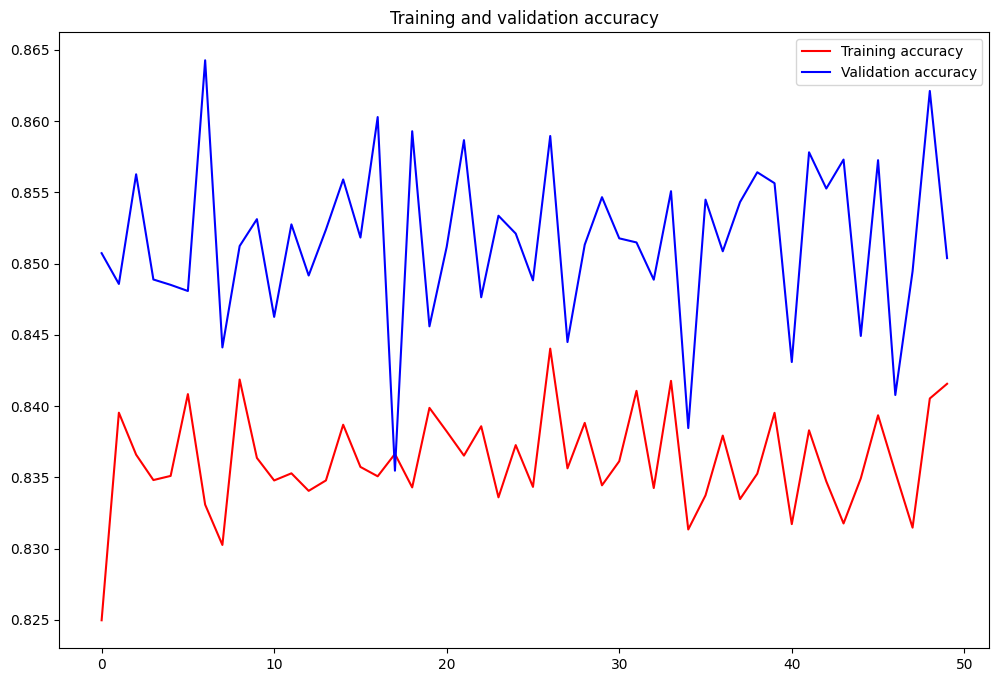

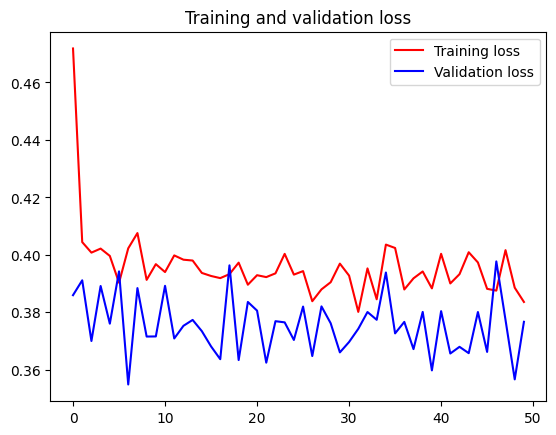

In [14]:
plot_history(vgg16_history)

10/10 [==============================] - 1s 135ms/step


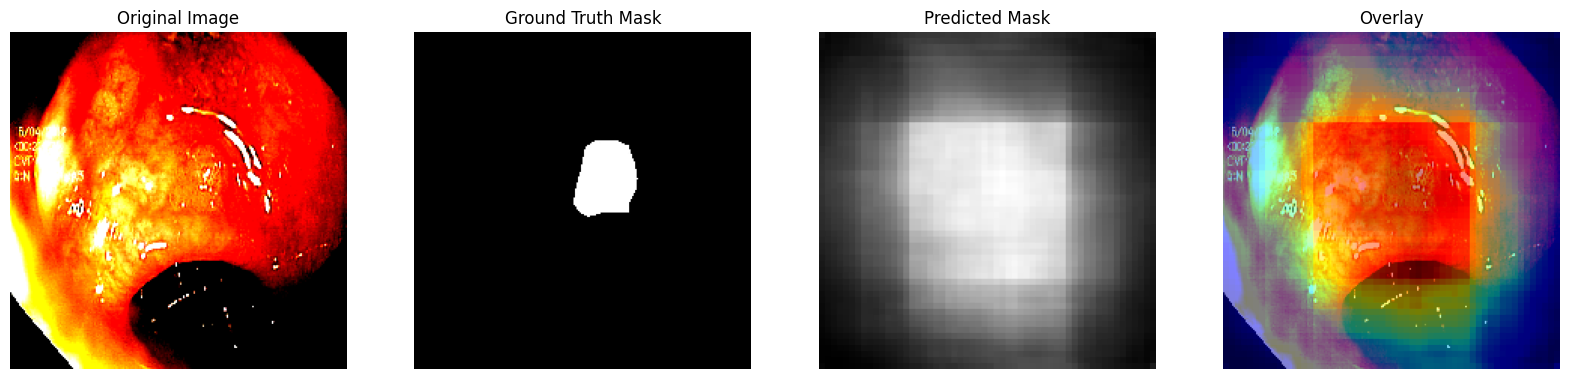

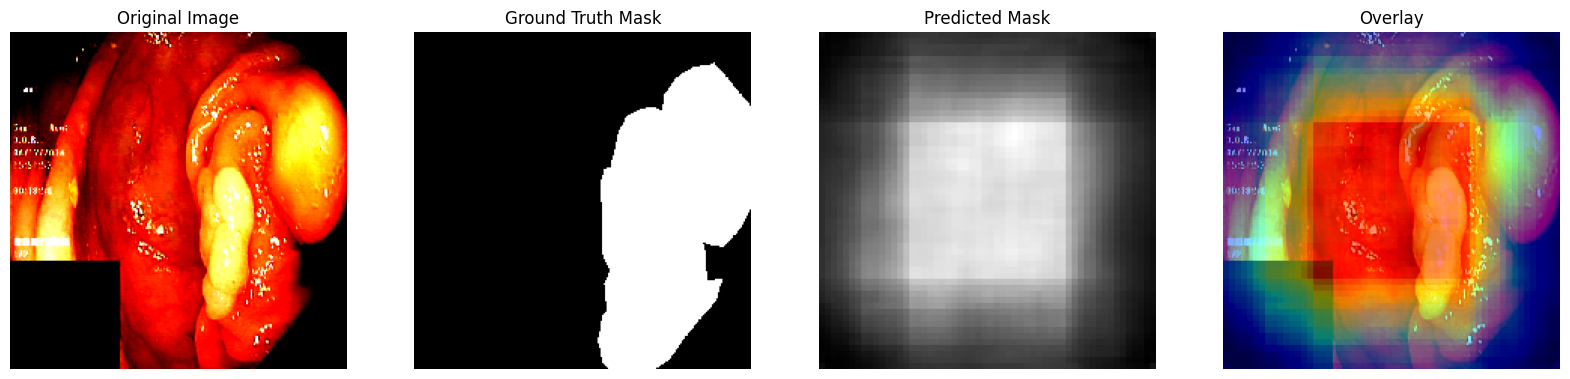

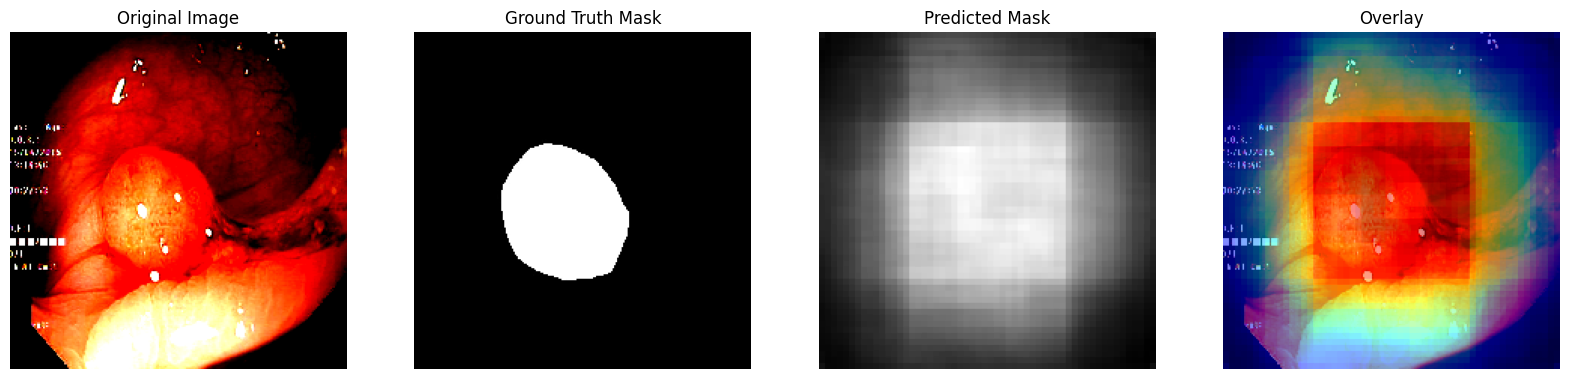

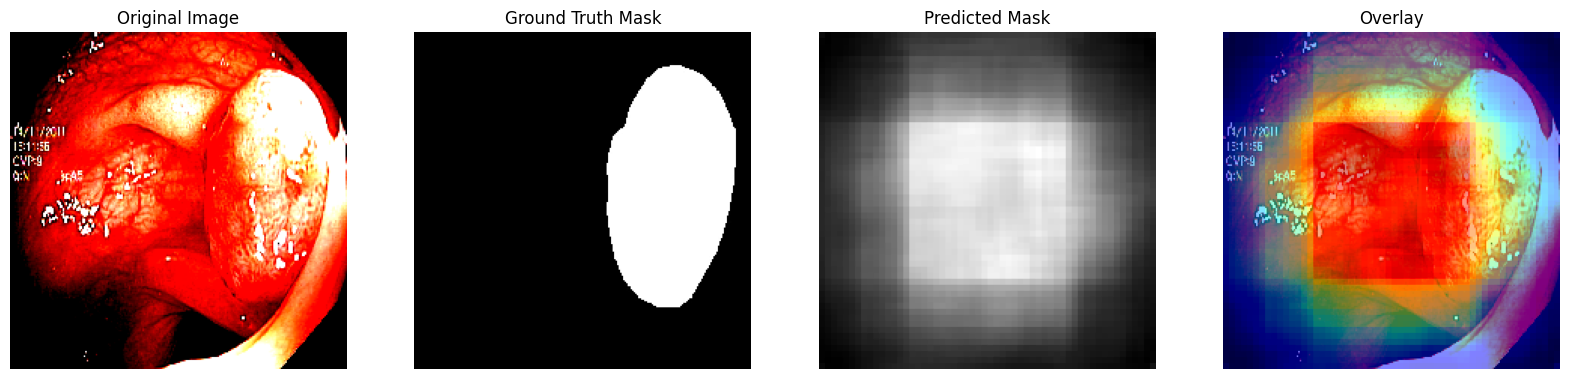

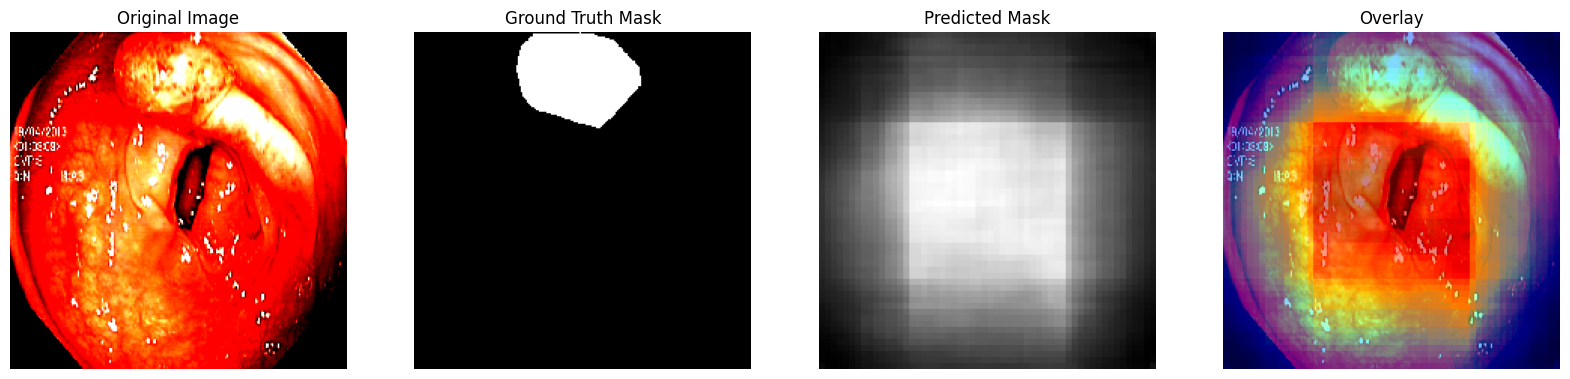

In [15]:
visualize_results(vgg16_model, test_images, test_masks)



---



---



# **Inception V3 model**

In [19]:
# InceptionV3 model for transfer learning
inceptionv3 = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Adding custom layers for segmentation
inputs = Input(shape=(224, 224, 3))
base_model = inceptionv3(inputs, training=False)

x = Conv2D(256, (3, 3), activation='relu', padding='same')(base_model)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
outputs = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x)

# Define the model
inceptionv3_model = Model(inputs, outputs)

# Freeze the InceptionV3 layers
for layer in inceptionv3.layers:
    layer.trainable = False

for layer in inceptionv3_model.layers[:-10]:
    layer.trainable = False

# Compile the model
inceptionv3_model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])


#The size change occurs because of the downsampling and upsampling operations in the neural network architecture.

def resize_masks_generator(image_gen, mask_gen, target_size=(160, 160)):
    for (img, mask) in zip(image_gen, mask_gen):
        resized_mask = tf.image.resize(mask, target_size)
        yield img, resized_mask

# Create combined generators with resized masks
train_generator_resized = resize_masks_generator(train_image_generator, train_mask_generator)
val_generator_resized = resize_masks_generator(val_image_generator, val_mask_generator)

test_masks_reshaped = test_masks.reshape(-1, 224, 224, 1)
test_masks_resized = tf.image.resize(test_masks_reshaped, (160, 160))

# Train the model
# inceptionv3_history = inceptionv3_model.fit(train_images, train_masks, epochs=50, batch_size=8, validation_split=0.2)

inceptionv3_history = inceptionv3_model.fit(train_generator_resized, epochs=50, steps_per_epoch=len(train_images) // 8, validation_data=val_generator_resized, validation_steps=len(val_images) // 8)

# Evaluate the model
loss, accuracy = inceptionv3_model.evaluate(test_images, test_masks_resized)
print(f'Loss: {loss}, Accuracy: {accuracy}')

Epoch 1/50
61/61 [==============================] - 21s 238ms/step - loss: 0.5054 - accuracy: 0.8031 - val_loss: 0.4216 - val_accuracy: 0.8459
Epoch 2/50
61/61 [==============================] - 18s 293ms/step - loss: 0.4233 - accuracy: 0.8357 - val_loss: 0.4199 - val_accuracy: 0.8476
Epoch 3/50
61/61 [==============================] - 13s 213ms/step - loss: 0.4245 - accuracy: 0.8314 - val_loss: 0.3902 - val_accuracy: 0.8487
Epoch 4/50
61/61 [==============================] - 13s 222ms/step - loss: 0.4089 - accuracy: 0.8329 - val_loss: 0.3955 - val_accuracy: 0.8505
Epoch 5/50
61/61 [==============================] - 17s 279ms/step - loss: 0.4080 - accuracy: 0.8326 - val_loss: 0.3961 - val_accuracy: 0.8417
Epoch 6/50
61/61 [==============================] - 12s 195ms/step - loss: 0.4138 - accuracy: 0.8221 - val_loss: 0.3823 - val_accuracy: 0.8475
Epoch 7/50
61/61 [==============================] - 15s 248ms/step - loss: 0.3971 - accuracy: 0.8405 - val_loss: 0.3932 - val_accuracy: 0.8513

In [ ]:
loss, accuracy = inceptionv3_model.evaluate(test_images, test_masks_resized)
print(f'Loss: {loss}, Accuracy: {accuracy}')

10/10 [==============================] - 1s 76ms/step - loss: 0.9623 - accuracy: 0.8464
Loss: 0.9622805714607239, Accuracy: 0.8463574051856995


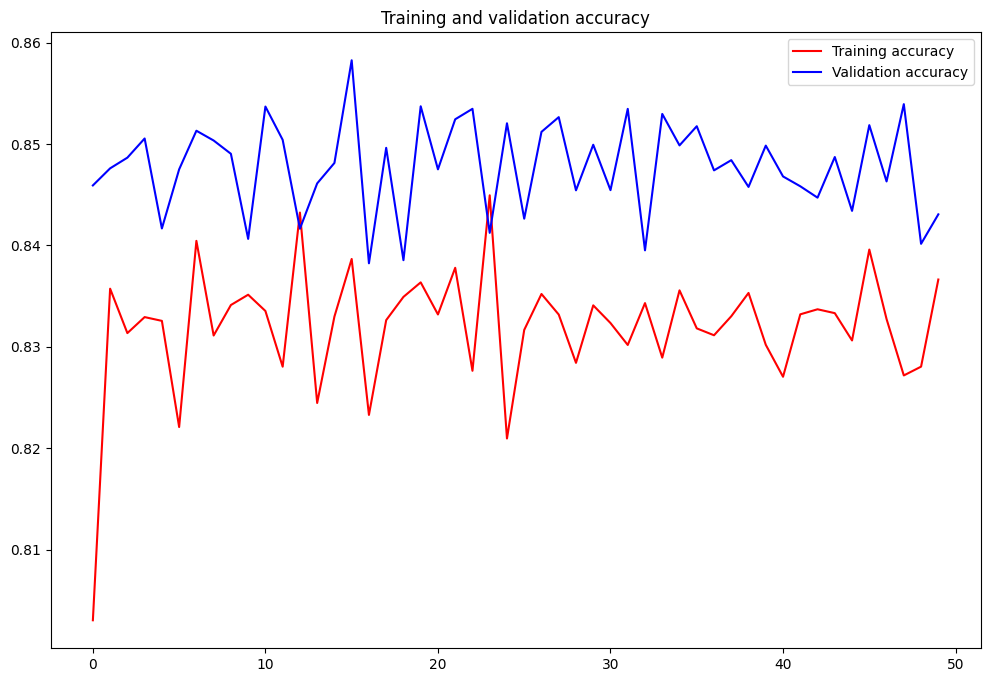

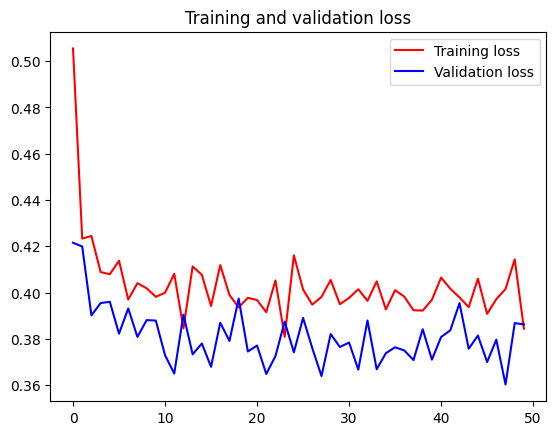

In [20]:
plot_history(inceptionv3_history)

10/10 [==============================] - 2s 78ms/step


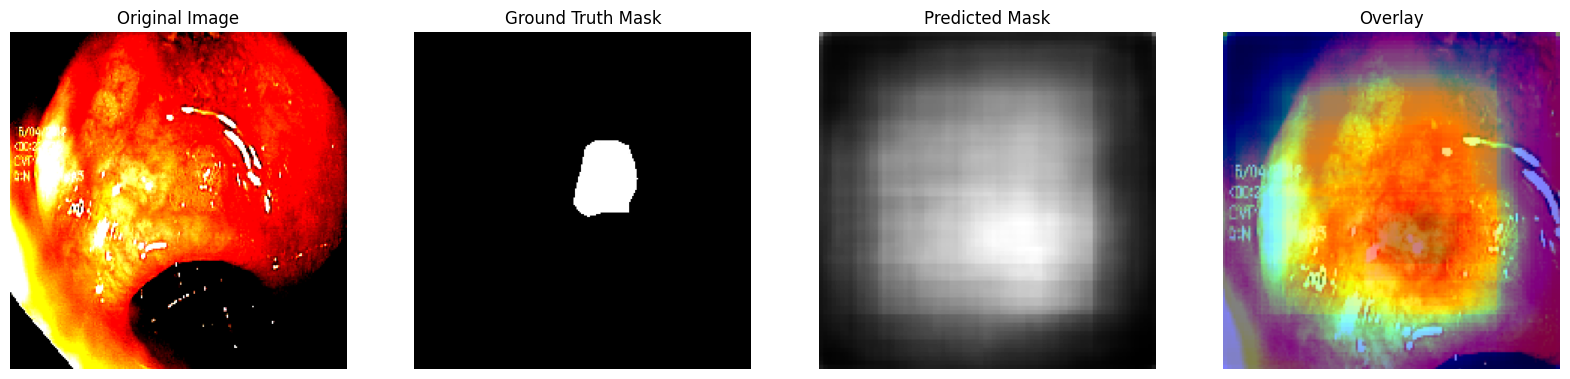

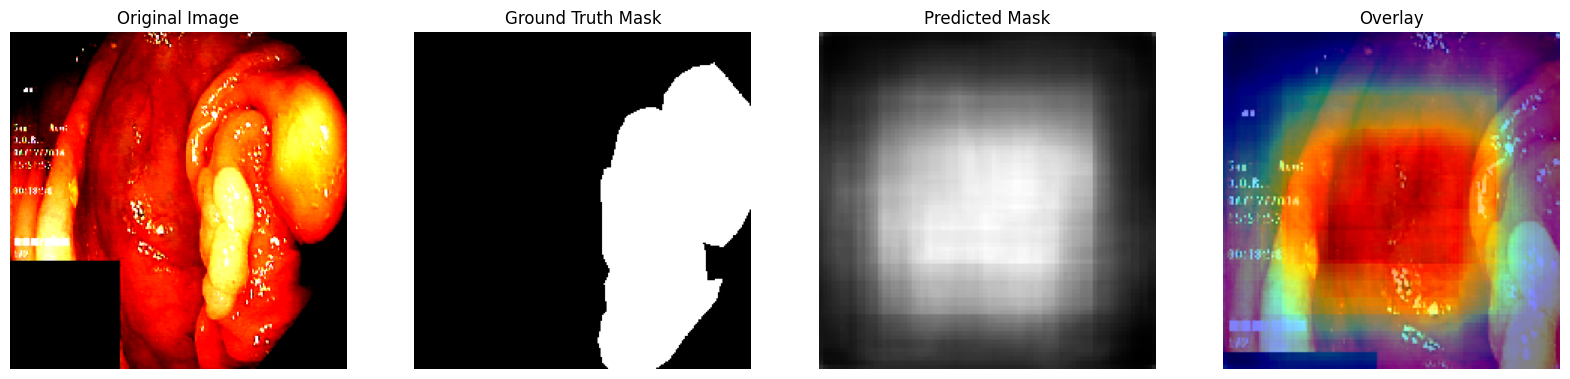

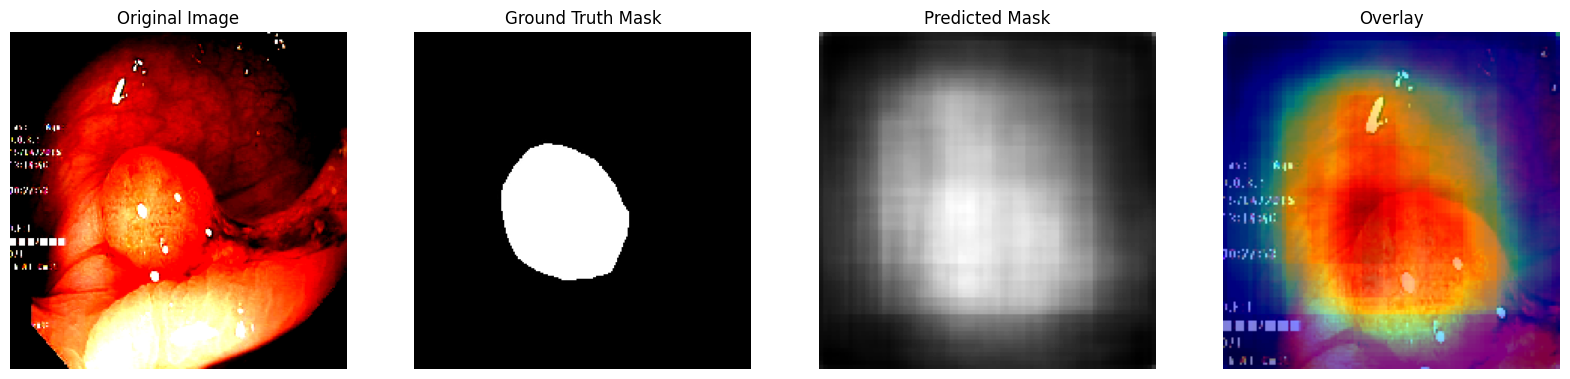

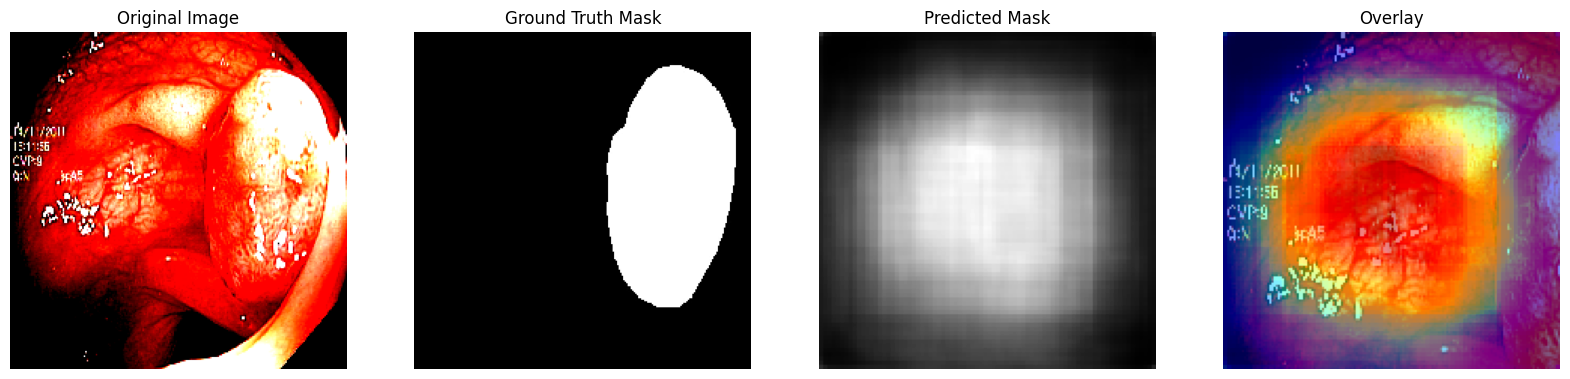

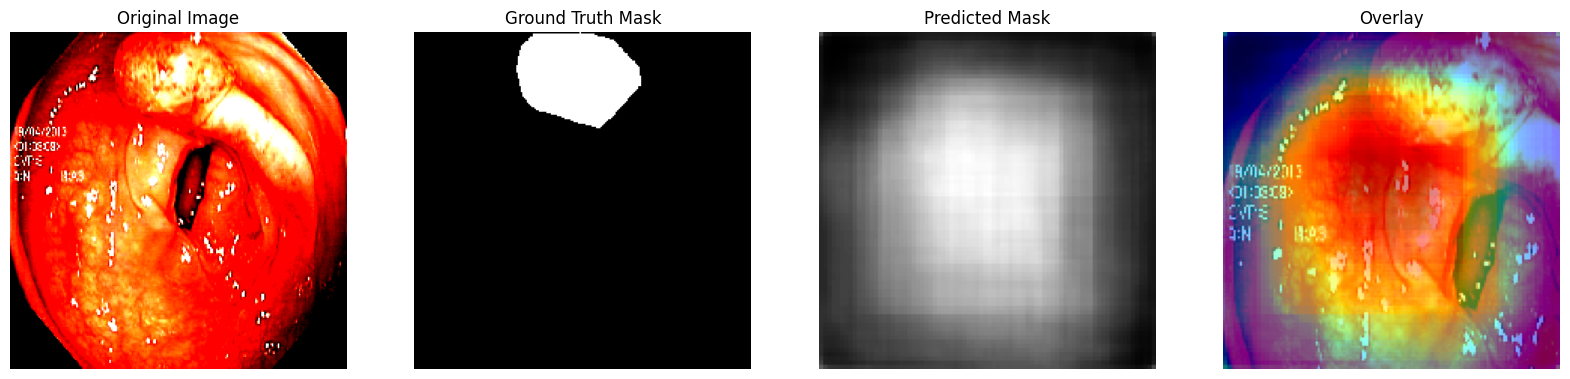

In [21]:
visualize_results(inceptionv3_model, test_images, test_masks)

# **ResNet50**

In [22]:
# ResNet50 model for transfer learning
resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Adding custom layers for segmentation
inputs = Input(shape=(224, 224, 3))
base_model = resnet50(inputs, training=False)

x = Conv2D(256, (3, 3), activation='relu', padding='same')(base_model)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
outputs = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x)

# Define the model
resnet50_model = Model(inputs, outputs)

# Freeze the ResNet50 layers
for layer in resnet50.layers:
    layer.trainable = False

# Freeze layers except for the last 10 layers
for layer in resnet50_model.layers[:-10]:
    layer.trainable = False

# Compile the model
resnet50_model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Resize target masks to match model output
# Ensure masks have the correct shape
train_masks_reshaped = train_masks.reshape(-1, 224, 224, 1)
val_masks_reshaped = val_masks.reshape(-1, 224, 224, 1)
test_masks_reshaped = test_masks.reshape(-1, 224, 224, 1)

# Resize target masks to match model output
train_masks_resized = tf.image.resize(train_masks_reshaped, (224, 224))
val_masks_resized = tf.image.resize(val_masks_reshaped, (224, 224))
test_masks_resized = tf.image.resize(test_masks_reshaped, (224, 224))

# Train the model
resnet50_history = resnet50_model.fit(train_generator, epochs=50, steps_per_epoch=len(train_images) // 8, validation_data=val_generator, validation_steps=len(val_images) // 8)

# Evaluate the model
loss, accuracy = resnet50_model.evaluate(test_images, test_masks_resized)
print(f'Loss: {loss}, Accuracy: {accuracy}')


94765736/94765736 [==============================] - 1s 0us/step
Epoch 1/50
61/61 [==============================] - 22s 238ms/step - loss: 0.4717 - accuracy: 0.8110 - val_loss: 0.3890 - val_accuracy: 0.8464
Epoch 2/50
61/61 [==============================] - 13s 212ms/step - loss: 0.4090 - accuracy: 0.8370 - val_loss: 0.3955 - val_accuracy: 0.8481
Epoch 3/50
61/61 [==============================] - 12s 205ms/step - loss: 0.4005 - accuracy: 0.8322 - val_loss: 0.3707 - val_accuracy: 0.8579
Epoch 4/50
61/61 [==============================] - 13s 223ms/step - loss: 0.3914 - accuracy: 0.8396 - val_loss: 0.3565 - val_accuracy: 0.8637
Epoch 5/50
61/61 [==============================] - 14s 225ms/step - loss: 0.3947 - accuracy: 0.8363 - val_loss: 0.3894 - val_accuracy: 0.8478
Epoch 6/50
61/61 [==============================] - 17s 282ms/step - loss: 0.4033 - accuracy: 0.8308 - val_loss: 0.3879 - val_accuracy: 0.8471
Epoch 7/50
61/61 [==============================] - 15s 254ms/step - loss: 0.

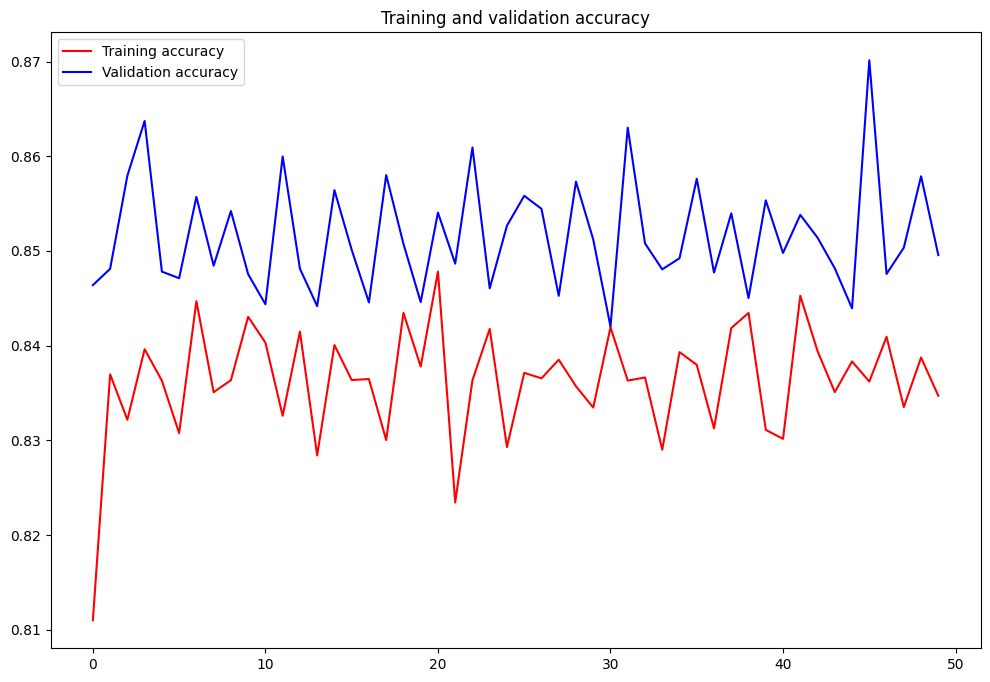

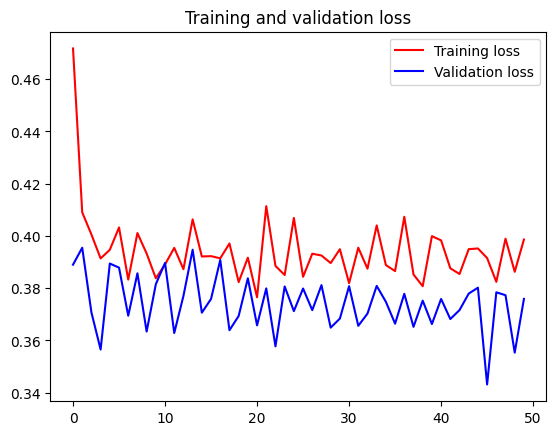

In [23]:
plot_history(resnet50_history)

10/10 [==============================] - 2s 102ms/step


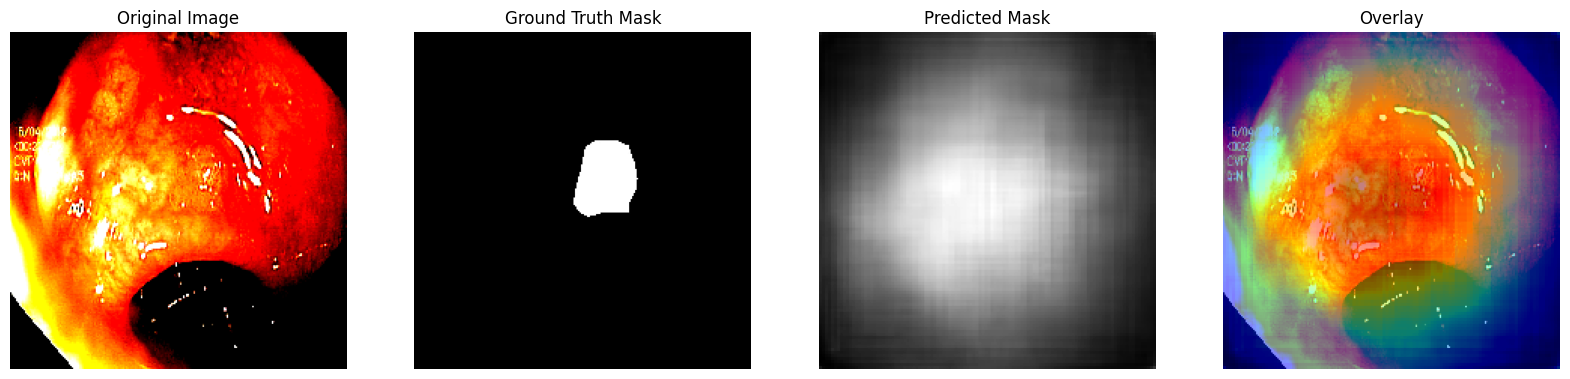

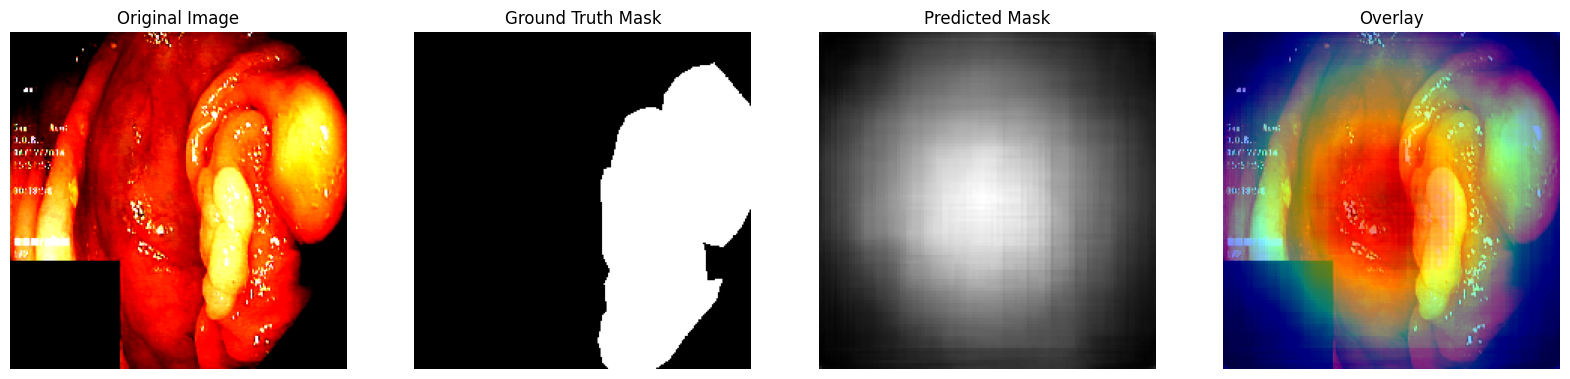

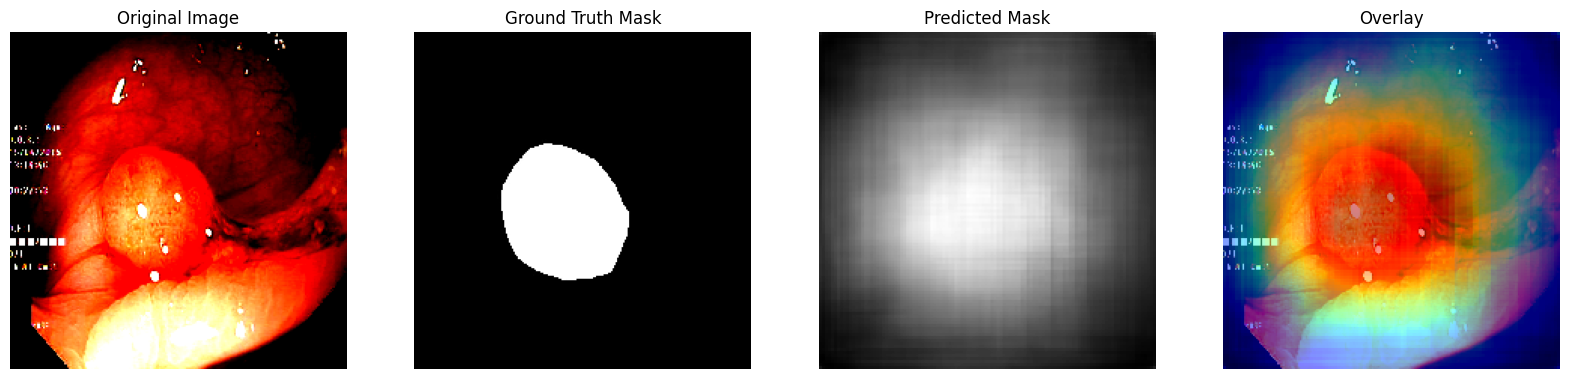

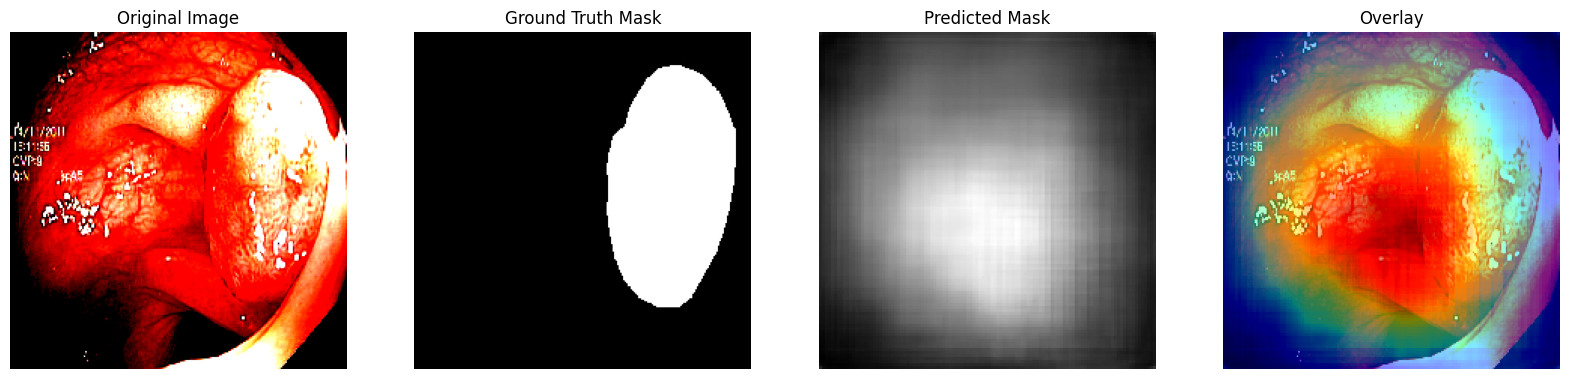

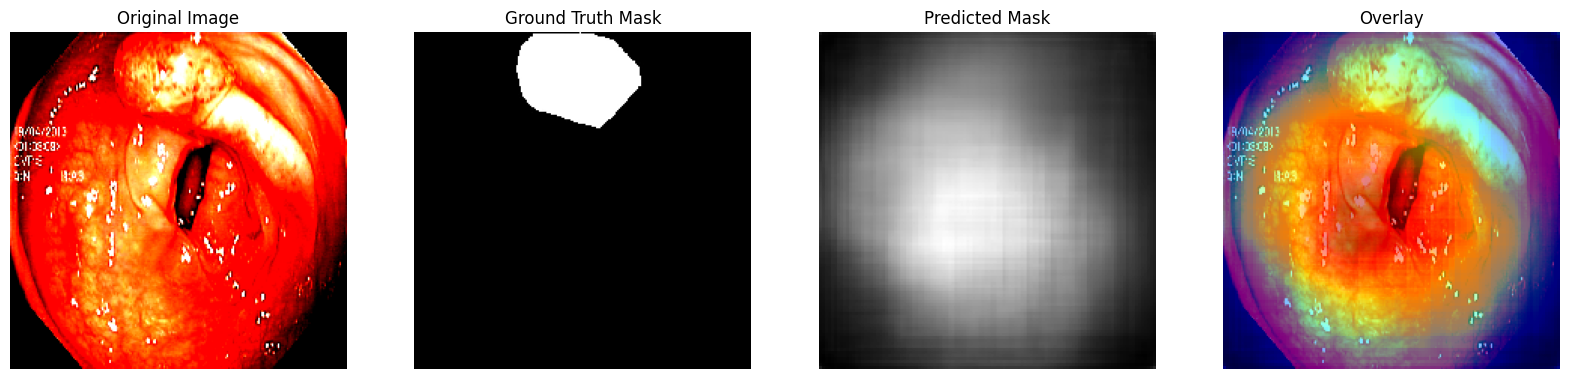

In [24]:
visualize_results(resnet50_model, test_images, test_masks)